In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time


mockdata = np.load("../data/dataset_all_H1_bootstrap_O3a.npy")



In [18]:
mockdata.shape

(37800, 7)

In [19]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(6, 500)  # 6 input features
        self.fc2 = nn.Linear(500, 7)  # 7 output classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Raw logits, no activation
        return x


In [20]:
def train_model(device, trainingdata: torch.Tensor, trainingresult: torch.Tensor, epochs=10):
    model = SimpleNN().to(device)
    criterion = nn.CrossEntropyLoss()  # Multiclass classification loss
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Move data to device
    x = trainingdata.float().to(device)
    y = trainingresult.long().to(device)  # Targets must be of type LongTensor

    # Debugging: Check input/output shapes
    print("Training data shape:", x.shape)
    print("Target shape:", y.shape)

    start_time = time.time()

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x)  # Forward pass (logits)
        print("Model output shape:", outputs.shape)  # Debugging
        loss = criterion(outputs, y)  # Compute loss
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")  # Log loss
        loss.backward()
        optimizer.step()

    elapsed_time = time.time() - start_time
    print(f"Training completed on {device} in {elapsed_time:.2f} seconds")
    return model


In [21]:
# Prepare features and labels
features = mockdata[:, :6]  # First 6 columns for features
labels = mockdata[:, 6]     # 7th column for class labels (multiclass)

# Ensure labels are integers (already assumed to be 0 to 6)
labels = labels.astype(np.int64)  # Convert to int64 for PyTorch compatibility

print("Unique target classes:", np.unique(labels))


Unique target classes: [0 1 2 3 4 5 6]


In [22]:
print("\nTraining")

device = torch.device("cuda")

model = train_model(
    device,
    torch.from_numpy(features),
    torch.from_numpy(labels),
    epochs = 10000
)



Training
Training data shape: torch.Size([37800, 6])
Target shape: torch.Size([37800])
Model output shape: torch.Size([37800, 7])
Epoch 1/10000, Loss: 13.640836715698242
Model output shape: torch.Size([37800, 7])
Epoch 2/10000, Loss: 791.3126220703125
Model output shape: torch.Size([37800, 7])
Epoch 3/10000, Loss: 406.4208984375
Model output shape: torch.Size([37800, 7])
Epoch 4/10000, Loss: 48.742958068847656
Model output shape: torch.Size([37800, 7])
Epoch 5/10000, Loss: 31.46929931640625
Model output shape: torch.Size([37800, 7])
Epoch 6/10000, Loss: 26.555177688598633
Model output shape: torch.Size([37800, 7])
Epoch 7/10000, Loss: 22.58125877380371
Model output shape: torch.Size([37800, 7])
Epoch 8/10000, Loss: 19.206754684448242
Model output shape: torch.Size([37800, 7])
Epoch 9/10000, Loss: 16.27481460571289
Model output shape: torch.Size([37800, 7])
Epoch 10/10000, Loss: 13.68712329864502
Model output shape: torch.Size([37800, 7])
Epoch 11/10000, Loss: 11.385185241699219
Model 

In [23]:
def plot_probability_distribution(model, feature_data, feature_3_idx=2, feature_4_idx=3, resolution=100, device='cuda'):
    """
    Plots the probability distribution in the plane of the third and fourth feature.

    Parameters:
        model: Trained PyTorch model.
        feature_data: Original feature data (to determine the range of features).
        feature_3_idx: Index of the third feature (default: 2).
        feature_4_idx: Index of the fourth feature (default: 3).
        resolution: Number of points along each axis in the grid (default: 100).
        device: Device to run the computation on ('cuda' or 'cpu').
    """
    # Transfer the model to the specified device
    model = model.to(device)

    # Determine the ranges for the third and fourth features
    feature_3_range = np.linspace(feature_data[:, feature_3_idx].min(), feature_data[:, feature_3_idx].max(), resolution)
    feature_4_range = np.linspace(feature_data[:, feature_4_idx].min(), feature_data[:, feature_4_idx].max(), resolution)

    # Create a mesh grid
    grid_x, grid_y = np.meshgrid(feature_3_range, feature_4_range)

    # Prepare input data for the model
    grid_points = np.c_[grid_x.ravel(), grid_y.ravel()]  # Flatten grid
    num_features = feature_data.shape[1]
    
    # Fix other features to their mean values
    fixed_features = np.mean(feature_data, axis=0)
    input_data = np.tile(fixed_features, (grid_points.shape[0], 1))
    input_data[:, feature_3_idx] = grid_points[:, 0]
    input_data[:, feature_4_idx] = grid_points[:, 1]

    # Convert to PyTorch tensor and transfer to device
    input_tensor = torch.from_numpy(input_data).float().to(device)

    # Use the model to compute probabilities
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        logits = model(input_tensor)
        probabilities = torch.softmax(logits, dim=1).cpu().numpy()  # Convert to probabilities and move to CPU for plotting

    # Reshape probabilities for plotting
    prob_class_0 = probabilities[:, 6].reshape(resolution, resolution)  # Example: probabilities for class 0

    # Plot the probability distribution
    plt.figure(figsize=(8, 6))
    plt.contourf(grid_x, grid_y, prob_class_0, levels=50, cmap='viridis')
    plt.colorbar(label="Probability of Class 6")
    plt.xlabel(f"Feature m1")
    plt.ylabel(f"Feature m2")
    plt.title("Probability Distribution for Class 6")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([20, 800])
    plt.ylim([2, 300])
    plt.show()


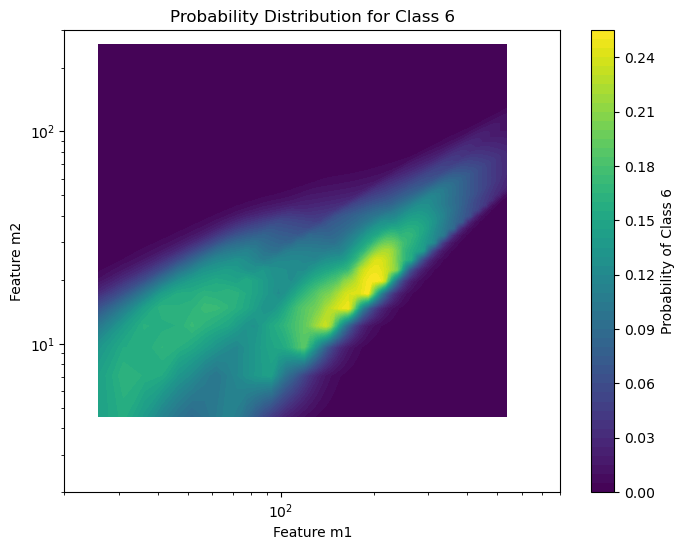

In [24]:
# Example usage
# features = mockdata[:, :6]  # First 6 columns as features

plot_probability_distribution(model, features, device='cuda')
